<a href="https://colab.research.google.com/github/CryingBI/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Thêm thư viện
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Lấy dữ liệu từ bộ MNIST
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
# Tiền xử lý dữ liệu, reshape từ ảnh xám 28*28 thành vector 784 chiều và đưa dữ liệu từ scale [0, 255] về [0, 1]
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [3]:
# Số chiều noise vector
z_dim = 100

In [4]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Mô hình Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
# Vì dữ liệu ảnh MNIST đã chuẩn hóa về [0, 1] nên hàm G khi sinh ảnh ra cũng cần sinh ra ảnh có pixel value trong khoảng [0, 1] => hàm sigmoid được chọn
g.add(Dense(784, activation='sigmoid'))  
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Mô hình Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
# Hàm sigmoid cho bài toán binary classification 
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hàm vẽ sample từ Generator
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    # Tính số lần chạy trong mỗi epoch
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy ngẫu nhiên các ảnh từ MNIST dataset (ảnh thật)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Sinh ra noise ngẫu nhiên
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Dùng Generator sinh ra ảnh từ noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Tạo label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # gán label bằng 1 cho những ảnh từ MNIST dataset và 0 cho ảnh sinh ra bởi Generator

            # Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator -> cố gắng lừa Discriminator. 
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thì không cập nhật hệ số của Discriminator.
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


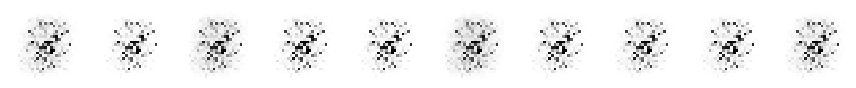

--------------- Epoch 20 ---------------


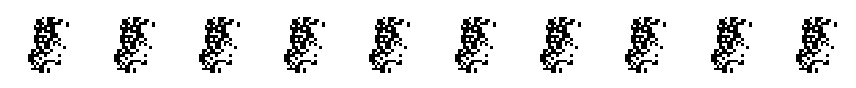

In [ ]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)